In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [82]:
# Load QVI_data datasetall
QVI2 = pd.read_csv('QVI_data.csv')
QVI2.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


### CHecking for null

In [84]:
QVI2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [86]:


QVI2["DATE"] = pd.to_datetime(qvi["DATE"])
QVI2["YEARMONTH"] = qvi["DATE"].dt.strftime("%Y%m").astype("int")

### Data Insception and Prepration

each stores monthly:

total sales revenue


total number of customers

average number of transactions per customer

Average chips per customer

Average price per unit


In [89]:

def monthly_store_metrics():
    store_yrmo_group = QVI2.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique()
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics

In [91]:
QVI2_monthly_metrics = monthly_store_metrics().reset_index()
QVI2_monthly_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3169 non-null   int64  
 1   YEARMONTH        3169 non-null   int32  
 2   TOT_SALES        3169 non-null   float64
 3   nCustomers       3169 non-null   int64  
 4   nTxnPerCust      3169 non-null   float64
 5   nChipsPerTxn     3169 non-null   float64
 6   avgPricePerUnit  3169 non-null   float64
dtypes: float64(4), int32(1), int64(2)
memory usage: 161.1 KB


Pre-Trial Observation as this filter only stores with full 12 months observation

In [96]:
observ_counts = QVI2_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = QVI2_monthly_metrics[QVI2_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEARMONTH"] < 201902]

pretrial_full_observ.head(8)

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
5,1,201812,189.6,42,1.119048,1.357143,3.326316
6,1,201901,154.8,35,1.028571,1.200000,3.685714
12,2,201807,150.8,39,1.051282,1.179487,3.278261


In [100]:

def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
  control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
  corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
  trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
  for control in control_store_nbrs:
    concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
    concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
    concat_df["Trial_Str"] = storeComparison
    concat_df["Ctrl_Str"] = control
    concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
    corrs = pd.concat([corrs, concat_df])
  return corrs

In [102]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
corr_table.head(8)

C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corrs = pd.concat([corrs, concat_df])
C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corrs = pd.concat([corrs, concat_df])
C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wil

,YEARMONTH,Trial_Str,Ctrl_Str,Corr_Score
0,201807,77,1,0.070414
1,201808,77,1,0.027276
2,201809,77,1,0.002389
3,201810,77,1,-0.020045
4,201811,77,1,0.030024
5,201812,77,1,0.063946
6,201901,77,1,0.001470
0,201807,77,2,0.142957


In [104]:
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists

In [106]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
dist_table.head(8)
dist_table
     

,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,0.935431,0.980769,0.958035,0.739412,0.883569,201807,77,1,0.899443
1,0.942972,0.951923,0.993823,0.802894,0.886328,201808,77,1,0.915588
2,0.961503,0.836538,0.992126,0.730041,0.703027,201809,77,1,0.844647
3,0.988221,0.932692,0.989514,0.940460,0.590528,201810,77,1,0.888283
4,0.962149,0.951923,0.874566,0.730358,0.832481,201811,77,1,0.870296
...,...,...,...,...,...,...,...,...,...
2,0.207554,0.286822,0.462846,0.779879,0.923887,201809,88,272,0.532198
3,0.346797,0.387597,0.571497,0.796875,0.971133,201810,88,272,0.614780
4,0.286706,0.310078,0.623883,0.813241,0.966999,201811,88,272,0.600181
5,0.347151,0.387597,0.376456,0.699748,0.962198,201812,88,272,0.554630


l select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores by using correlation and magnitude distance.

In [114]:

def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine


compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])
     

C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corrs = pd.concat([corrs, concat_df])
C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corrs = pd.concat([corrs, concat_df])
C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wil

In [116]:


corr_weight = 0.5
dist_weight = 1 - corr_weight

the top 5 highest composite sccore for each trial based on total sales 

In [119]:

grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')
     

     Trial_Str  Ctrl_Str      YEARMONTH  Corr_Score  magnitude  CompScore
218         77       233  201822.571429         1.0   0.986477   0.993238
239         77       255  201822.571429         1.0   0.979479   0.989739
177         77       188  201822.571429         1.0   0.977663   0.988831
49          77        53  201822.571429         1.0   0.976678   0.988339
120         77       131  201822.571429         1.0   0.976267   0.988134 

     Trial_Str  Ctrl_Str      YEARMONTH  Corr_Score  magnitude  CompScore
356         86       109  201822.571429         1.0   0.966783   0.983391
401         86       155  201822.571429         1.0   0.965876   0.982938
464         86       222  201822.571429         1.0   0.962280   0.981140
467         86       225  201822.571429         1.0   0.960512   0.980256
471         86       229  201822.571429         1.0   0.951704   0.975852 

     Trial_Str  Ctrl_Str      YEARMONTH  Corr_Score  magnitude  CompScore
551         88        40  201822.5

In [121]:

compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(["nCustomers"], trial_num)])
     


C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corrs = pd.concat([corrs, concat_df])
C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corrs = pd.concat([corrs, concat_df])
C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1861372410.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wil

the top 5 highest composite score for each trial based on no. of customers 

In [124]:
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')
     

     Trial_Str  Ctrl_Str      YEARMONTH  Corr_Score  magnitude  CompScore
218         77       233  201822.571429         1.0   0.993132   0.996566
38          77        41  201822.571429         1.0   0.976648   0.988324
101         77       111  201822.571429         1.0   0.968407   0.984203
105         77       115  201822.571429         1.0   0.967033   0.983516
15          77        17  201822.571429         1.0   0.965659   0.982830 

     Trial_Str  Ctrl_Str      YEARMONTH  Corr_Score  magnitude  CompScore
401         86       155  201822.571429         1.0   0.986772   0.993386
467         86       225  201822.571429         1.0   0.969577   0.984788
356         86       109  201822.571429         1.0   0.969577   0.984788
471         86       229  201822.571429         1.0   0.964286   0.982143
293         86        39  201822.571429         1.0   0.961640   0.980820 

     Trial_Str  Ctrl_Str      YEARMONTH  Corr_Score  magnitude  CompScore
736         88       237  201822.5

In [126]:
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    a = grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b = grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')
     

Trial_Str  Ctrl_Str
77         233         0.994902
           41          0.986020
           46          0.984762
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.988162
           109         0.984090
           225         0.982522
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.970895
           26          0.958929
           72          0.954079
dtype: float64 



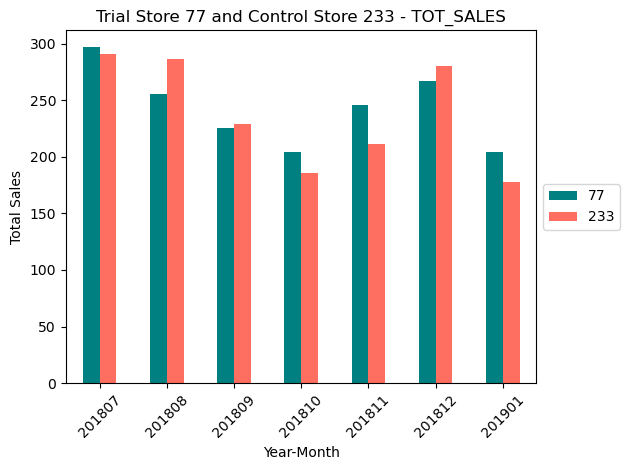

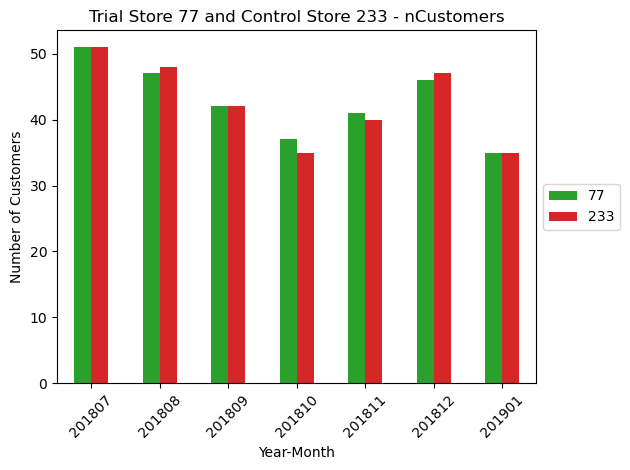

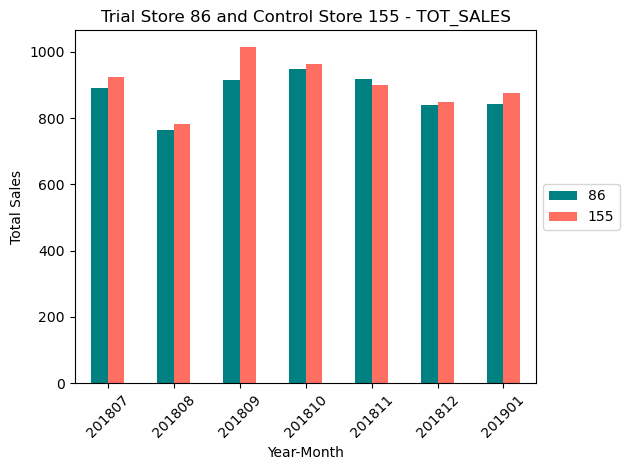

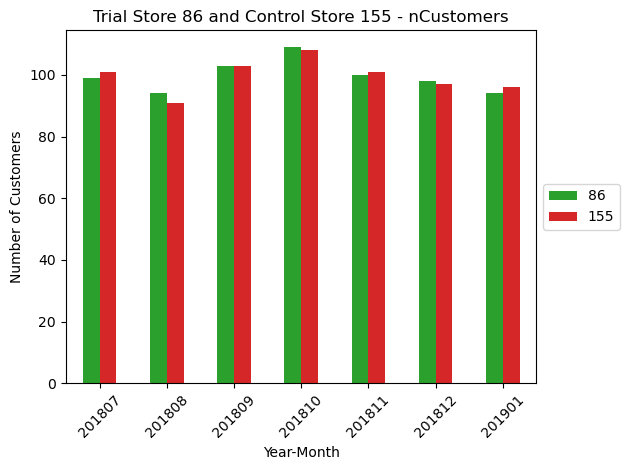

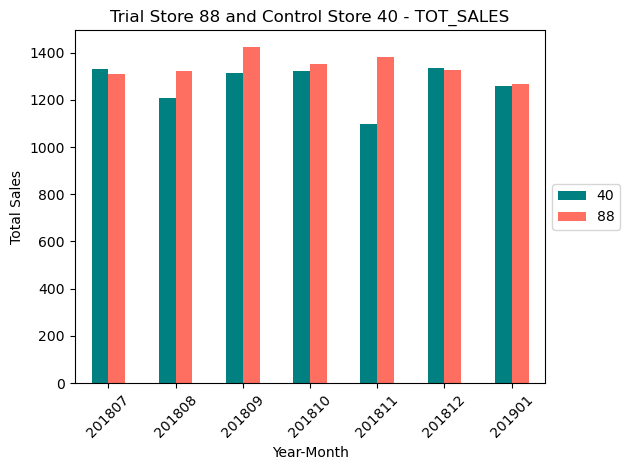

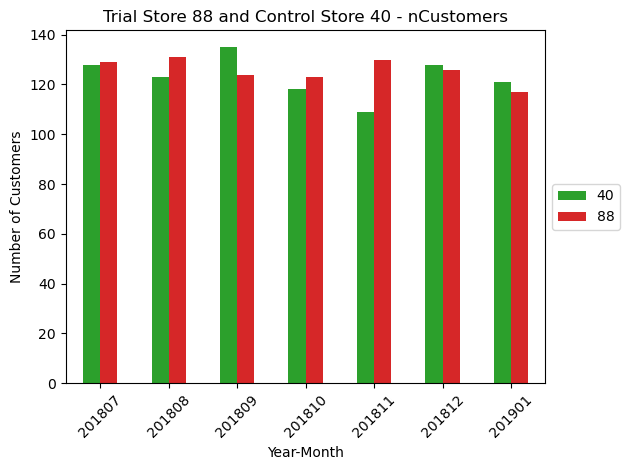

In [215]:
import matplotlib.pyplot as plt

trial_control_dic = {77: 233, 86: 155, 88: 40}

# Define a color palette for the bar charts
sales_color_palette = ['#008080', '#ff6f61']  # Teal and Coral
customers_color_palette = ['#2ca02c', '#d62728']  # Green and Red

for key, val in trial_control_dic.items():
    # Plot Total Sales
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].unstack().plot.bar(color=sales_color_palette)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store " + str(key) + " and Control Store " + str(val) + " - TOT_SALES")
    plt.ylabel("Total Sales")
    plt.xlabel("Year-Month")
    plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
    plt.show()
    
    # Plot Number of Customers
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].unstack().plot.bar(color=customers_color_palette)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store " + str(key) + " and Control Store " + str(val) + " - nCustomers")
    plt.ylabel("Number of Customers")
    plt.xlabel("Year-Month")
    plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
    plt.show()
    
    print('\n')


 compare the performance of Trial stores to Control stores during the trial period. To ensure their performance is comparable during Trial period, we need to scale (multiply to ratio of trial / control) all of Control stores' performance to Trial store's performance during pre-trial. Starting with TOT_SALES.

In [138]:
#Ratio of Store 77 and its Control store.
sales_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["TOT_SALES"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["TOT_SALES"].sum()

#Ratio of Store 77 and its Control store.
sales_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["TOT_SALES"].sum()
     


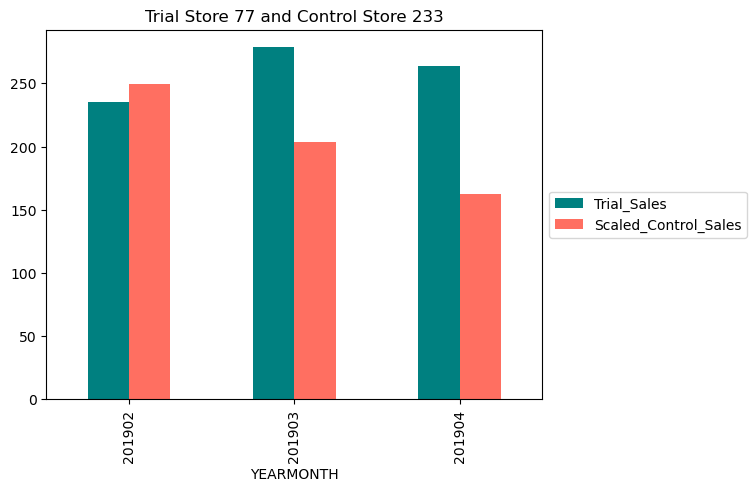

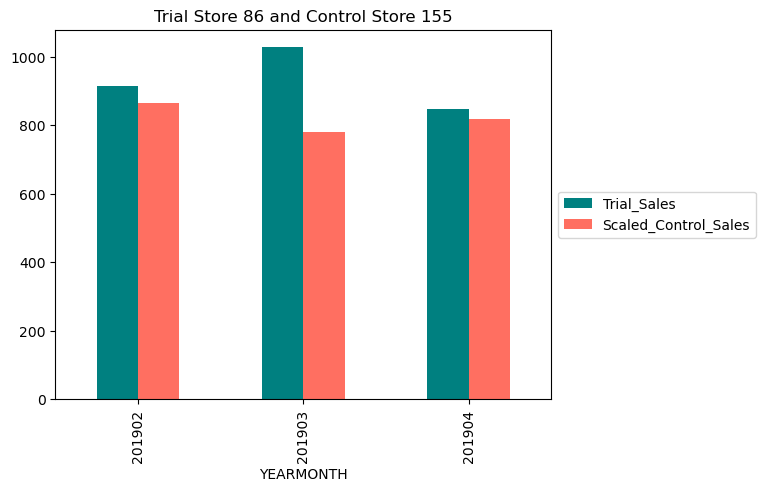

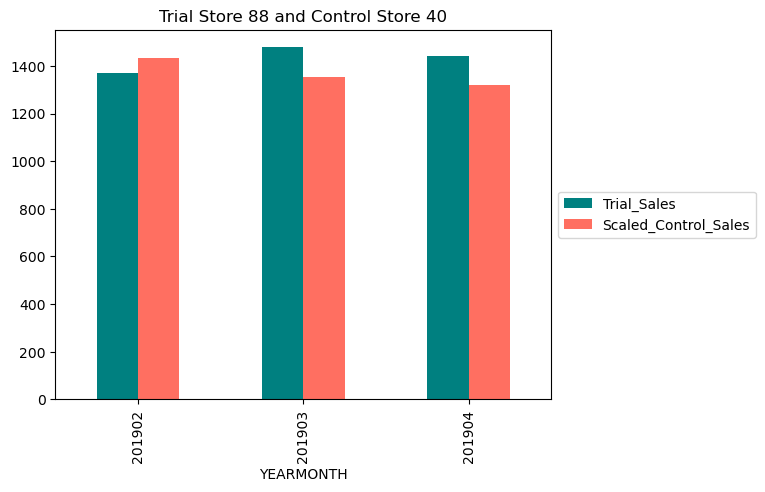

In [213]:
# Filter the relevant observations
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_sales_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]

# Function to scale sales based on store number
def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["TOT_SALES"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["TOT_SALES"] * sales_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["TOT_SALES"] * sales_ratio_88

# Apply the scaling function
scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)

# Define trial and pretrial datasets
trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["YEARMONTH"] >= 201902) & (scaled_sales_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["YEARMONTH"] < 201902]

# Dictionary to store percentage differences
percentage_diff = {}

# Define a color palette for the bar chart
color_palette = ['#008080', '#ff6f61']  # Teal and Coral

# Loop through trial and control store pairs
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]
    
    # Calculate percentage difference
    percentage_diff[trial] = b["TOT_SALES"].sum() / a["ScaledSales"].sum()
    
    # Merge dataframes for plotting
    plot_data = b[["YEARMONTH", "TOT_SALES"]].merge(a[["YEARMONTH", "ScaledSales"]], on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales": "Scaled_Control_Sales", "TOT_SALES": "Trial_Sales"})
    
    # Plot the bar chart with custom colors
    plot_data.plot.bar(color=color_palette)
    
    # Add legend and title
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store " + str(trial) + " and Control Store " + str(control))
    
    # Save the figure if needed
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial, control), bbox_inches="tight")
    plt.show()  # Optional: Display the plot


In [142]:
percentage_diff

{77: 1.2615468650086281, 86: 1.1315014357363697, 88: 1.043458345854219}

In [144]:
temp1 = scaled_sales_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["TOT_SALES", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledSales", "t_STORE_NBR", "t_TOT_SALES"]
scaledsales_vs_trial["Sales_Percentage_Diff"] = (scaledsales_vs_trial["t_TOT_SALES"] - scaledsales_vs_trial["c_ScaledSales"]) / (((scaledsales_vs_trial["t_TOT_SALES"] + scaledsales_vs_trial["c_ScaledSales"])/2))
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
scaledsales_vs_trial["trial_period"] = scaledsales_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]
     


,c_STORE_NBR,YEARMONTH,c_ScaledSales,t_STORE_NBR,t_TOT_SALES,Sales_Percentage_Diff,trial_period
7,233,201902,249.762622,77,235.0,-0.060907,trial
8,233,201903,203.802205,77,278.5,0.309755,trial
9,233,201904,162.345704,77,263.5,0.475075,trial
19,155,201902,864.522060,86,913.2,0.054764,trial
20,155,201903,780.320405,86,1026.8,0.272787,trial
21,155,201904,819.317024,86,848.2,0.034642,trial
31,40,201902,1434.399269,88,1370.2,-0.045781,trial
32,40,201903,1352.064709,88,1477.2,0.088458,trial
33,40,201904,1321.797762,88,1439.4,0.085182,trial


Step 1: Formulate the null hypothesis asserting that there is no difference between the control store's performance during the pre-trial period and the trial period.

Step 2: Demonstrate statistically that the control and trial stores are similar.

Evaluate the p-value comparing the control store's pre-trial performance to the trial store's pre-trial performance. If the p-value is less than 5%, this indicates a statistically significant difference; if it is greater than 5%, the performance is deemed similar.

Step 3: Assuming the null hypothesis from the first two steps holds true, we will then examine the null hypothesis regarding the percentage difference between the trial and control stores during the pre-trial and trial periods.

Calculate the t-value for the percentage difference for each trial month (February, March, April 2019). The mean should be calculated from the percentage differences during the pre-trial period, and the standard deviation should be derived from those same differences. The formula for calculating the t-value is: (Trial month's percentage difference - Mean) / Standard deviation. Finally, compare each t-value against the critical t-value of 6 degrees of freedom (derived from 7 months of sample data - 1) at a 95% confidence level.

In [147]:
from scipy.stats import ttest_ind, t

# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   equal_var=False), '\n')
    #print(len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]), len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]))
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num])])-1))
     

Store 40
TtestResult(statistic=-0.5958372343168558, pvalue=0.5722861621434027, df=6.228548324256264) 

Store 155
TtestResult(statistic=1.4291956879290917, pvalue=0.1972705865160342, df=6.794437403919926) 

Store 233
TtestResult(statistic=1.191102601097452, pvalue=0.2944500606486209, df=4.355475642590669) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [149]:


a = pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]
b = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]
   


Null hypothesis is true. There isn't any statistically significant difference between control store's scaled Pre-Trial and Trial period sales.

In [152]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"],
                   pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"],
                   equal_var=True), '\n')
    #print(len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"]),len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"]))

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))
     

Trial store: 77 , Control store: 233
TtestResult(statistic=-1.2533353315065932e-15, pvalue=0.999999999999999, df=12.0) 

Trial store: 86 , Control store: 155
TtestResult(statistic=3.1048311203382156e-15, pvalue=0.9999999999999976, df=12.0) 

Trial store: 88 , Control store: 40
TtestResult(statistic=-5.69358613974361e-15, pvalue=0.9999999999999956, df=12.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


Null hypothesis is true. There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [155]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == cont) & (scaledsales_vs_trial["trial_period"]=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial["YEARMONTH"] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.7171038288055838
201903 : 3.035317928855674
201904 : 4.708944418758219


Trial store: 86 , Control store: 155
201902 : 1.4133618775921597
201903 : 7.123063846042147
201904 : 0.8863824572944234


Trial store: 88 , Control store: 40
201902 : -0.5481633746817577
201903 : 1.0089992743637823
201904 : 0.9710006270463672


Critical t-value for 95% confidence interval:
1.9431802803927816


C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\1265862777.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(t_month,":",(float(pdif)-mean)/std)


There are 3 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

March trial months for trial store 86

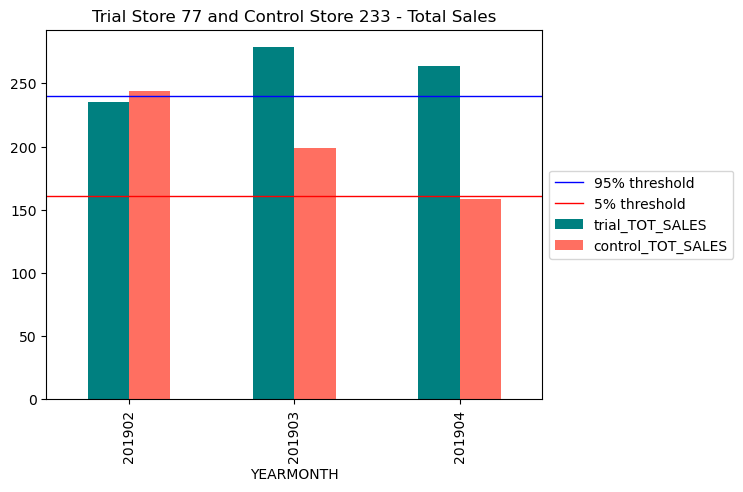

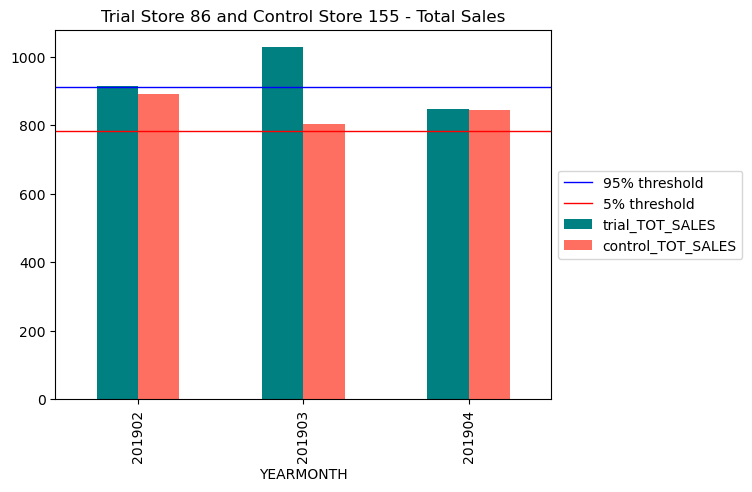

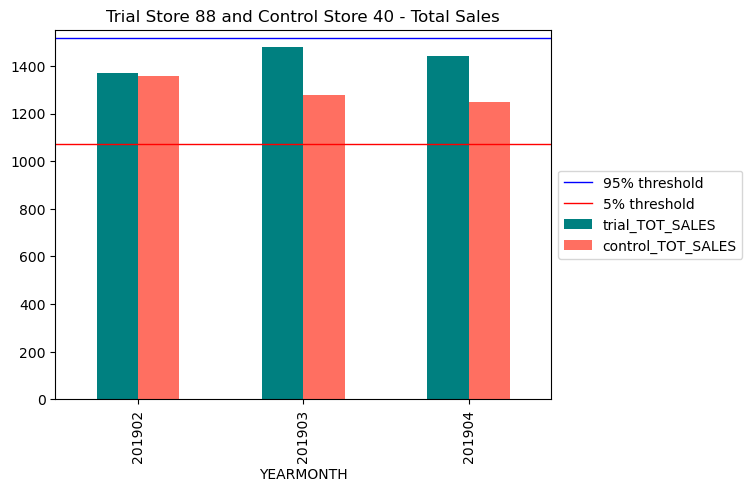

In [211]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control].rename(columns={"TOT_SALES": "control_TOT_SALES"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].rename(columns={"TOT_SALES": "trial_TOT_SALES"})
    
    # Combine the dataframes for plotting
    comb = b[["YEARMONTH", "trial_TOT_SALES"]].merge(a[["YEARMONTH", "control_TOT_SALES"]], on="YEARMONTH").set_index("YEARMONTH")
    
    # Define a color palette
    color_palette = ['#008080', '#ff6f61']  # Teal and Coral
    
    # Plotting the bar chart with custom colors
    comb.plot.bar(color=color_palette)
    
    # Calculate thresholds for the control store sales
    cont_sc_sales = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]["TOT_SALES"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"] == "pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_sales.mean() + (cont_sc_sales.mean() * std * 2)
    thresh5 = cont_sc_sales.mean() - (cont_sc_sales.mean() * std * 2)
    
    # Add horizontal lines for thresholds
    plt.axhline(y=thresh95, linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5, linewidth=1, color='r', label="5% threshold")
    
    # Add legend and title
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store " + str(trial) + " and Control Store " + str(control) + " - Total Sales")
    
    # Save the figure
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial, control), bbox_inches="tight")


In [205]:
#Ratio of Store 77 and its Control store.
ncust_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["nCustomers"].sum()

#Ratio of Store 86 and its Control store.
ncust_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["nCustomers"].sum()

#Ratio of Store 77 and its Control store.
ncust_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["nCustomers"].sum()
     

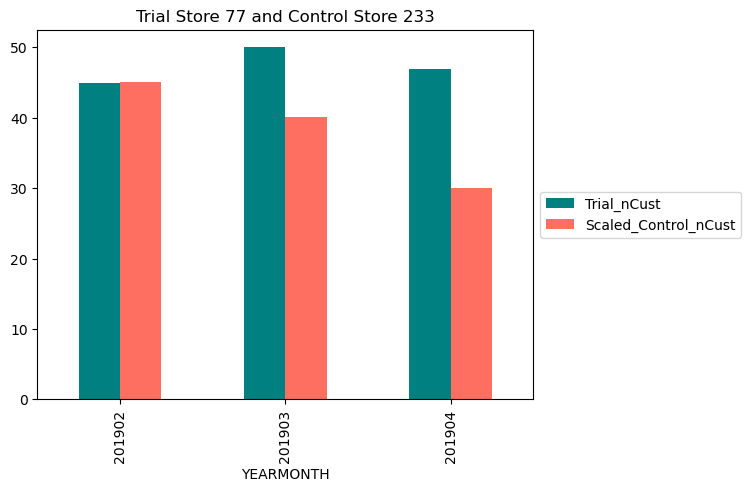

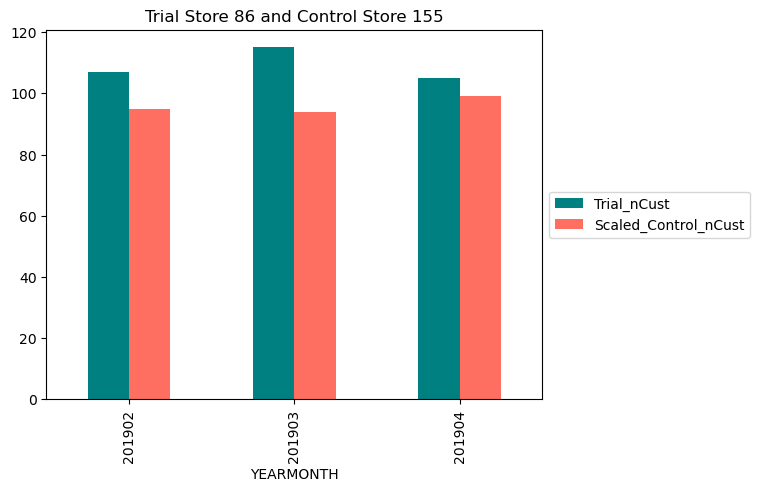

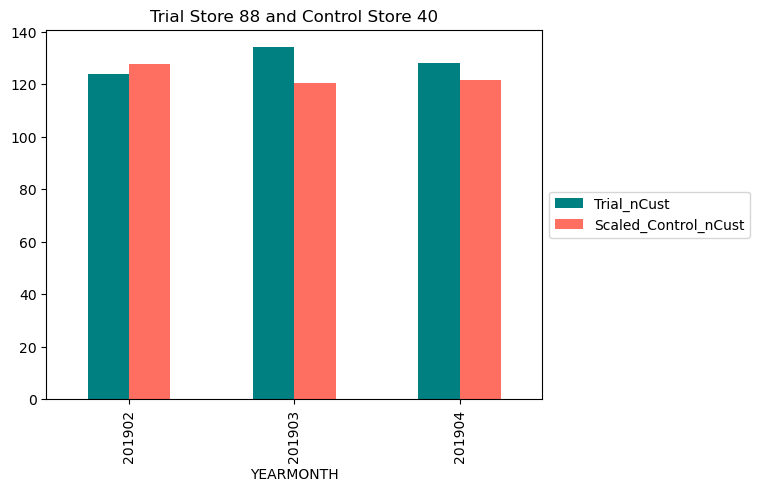

In [197]:
# Filter the data for the trial period
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_ncust_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "nCustomers"]]

def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["nCustomers"] * ncust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["nCustomers"] * ncust_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["nCustomers"] * ncust_ratio_88

# Apply the scaler function to calculate scaled customers
scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)

# Filter for trial and pretrial data
trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["YEARMONTH"] >= 201902) & (scaled_ncust_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["YEARMONTH"] < 201902]

# Dictionary to hold customer percentage differences
ncust_percentage_diff = {}

# Loop through trial and control stores to plot data
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]]
    
    # Calculate percentage difference
    ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()

    # Plot the bar chart with custom colors
    color_palette = ['#008080', '#ff6f61']  # Deep Blue and Teal
    b[["YEARMONTH", "nCustomers"]].merge(a[["YEARMONTH", "ScaledNcust"]], on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledNcust": "Scaled_Control_nCust", "nCustomers": "Trial_nCust"}).plot.bar(color=color_palette)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store " + str(trial) + " and Control Store " + str(control))


In [164]:
ncust_percentage_diff

{77: 1.2306529009742622, 86: 1.1354166666666667, 88: 1.0444876946258161}

In [166]:
temp1 = scaled_ncust_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["nCustomers", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "nCustomers"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledncust_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledncust_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledNcust", "t_STORE_NBR", "t_nCustomers"]
scaledncust_vs_trial["nCust_Percentage_Diff"] = (scaledncust_vs_trial["t_nCustomers"] - scaledncust_vs_trial["c_ScaledNcust"]) / (((scaledncust_vs_trial["t_nCustomers"] + scaledncust_vs_trial["c_ScaledNcust"])/2))

scaledncust_vs_trial["trial_period"] = scaledncust_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]
     


,c_STORE_NBR,YEARMONTH,c_ScaledNcust,t_STORE_NBR,t_nCustomers,nCust_Percentage_Diff,trial_period
7,233,201902,45.151007,77,45,-0.003350,trial
8,233,201903,40.134228,77,50,0.218913,trial
9,233,201904,30.100671,77,47,0.438370,trial
19,155,201902,95.000000,86,107,0.118812,trial
20,155,201903,94.000000,86,115,0.200957,trial
21,155,201904,99.000000,86,105,0.058824,trial
31,40,201902,127.610209,88,124,-0.028697,trial
32,40,201903,120.464037,88,134,0.106388,trial
33,40,201904,121.484919,88,128,0.052228,trial


Check significance of Trial minus Control stores nCustomers Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

In [169]:

# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   equal_var=False), '\n')
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num])])-1))
     

Store 40
TtestResult(statistic=0.644732693420032, pvalue=0.5376573016017127, df=7.7735551763644395) 

Store 155
TtestResult(statistic=1.3888888888888882, pvalue=0.204345986327886, df=7.572528547077964) 

Store 233
TtestResult(statistic=0.8442563765225701, pvalue=0.4559280037660254, df=3.2638055826510652) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [171]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["nCustomers"],
                   pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == cont]["ScaledNcust"],
                   equal_var=True), '\n')

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))
     

Trial store: 77 , Control store: 233
TtestResult(statistic=0.0, pvalue=1.0, df=12.0) 

Trial store: 86 , Control store: 155
TtestResult(statistic=0.0, pvalue=1.0, df=12.0) 

Trial store: 88 , Control store: 40
TtestResult(statistic=-7.648483953264653e-15, pvalue=0.999999999999994, df=12.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


In [173]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == cont) & (scaledncust_vs_trial["trial_period"]=="pre")]
    std = temp_pre["nCust_Percentage_Diff"].std()
    mean = temp_pre["nCust_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledncust_vs_trial[(scaledncust_vs_trial["YEARMONTH"] == t_month) & (scaledncust_vs_trial["t_STORE_NBR"] == trial)]["nCust_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.19886295797440687
201903 : 8.009609025380932
201904 : 16.114474772873923


Trial store: 86 , Control store: 155
201902 : 6.220524882227514
201903 : 10.52599074274189
201904 : 3.0763575852842706


Trial store: 88 , Control store: 40
201902 : -0.3592881735131531
201903 : 1.2575196020616801
201904 : 0.6092905590514273


Critical t-value for 95% confidence interval:
1.9431802803927816


C:\Users\Raman\AppData\Local\Temp\ipykernel_11988\3881378290.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(t_month,":",(float(pdif)-mean)/std)


There are 5 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

Feb, March and April trial months for trial store 86

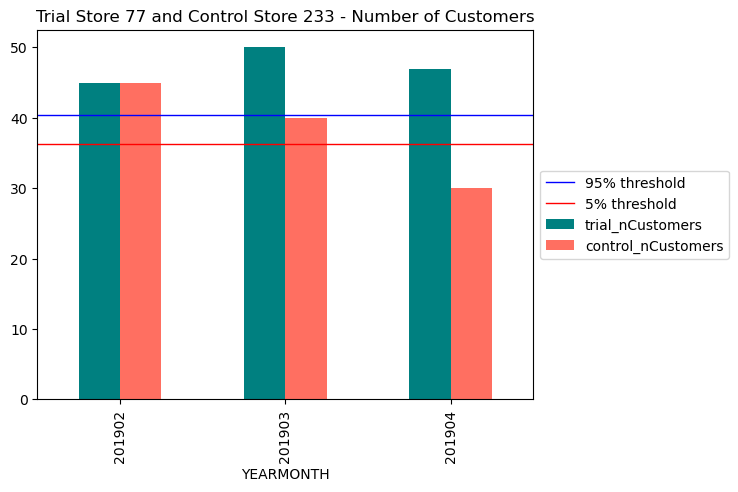

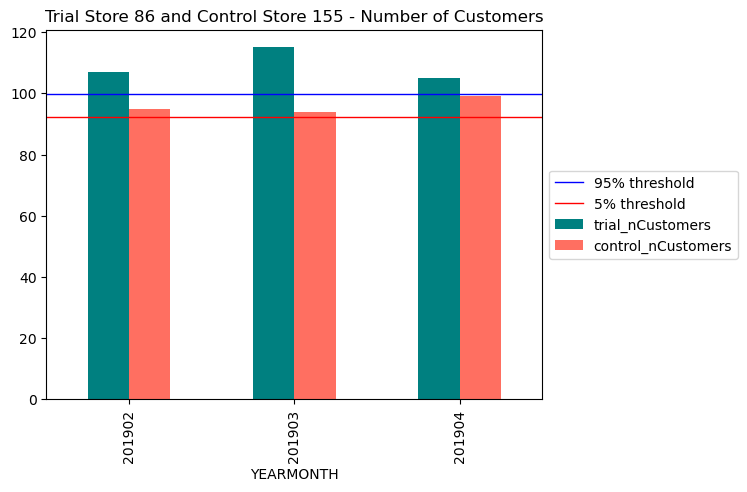

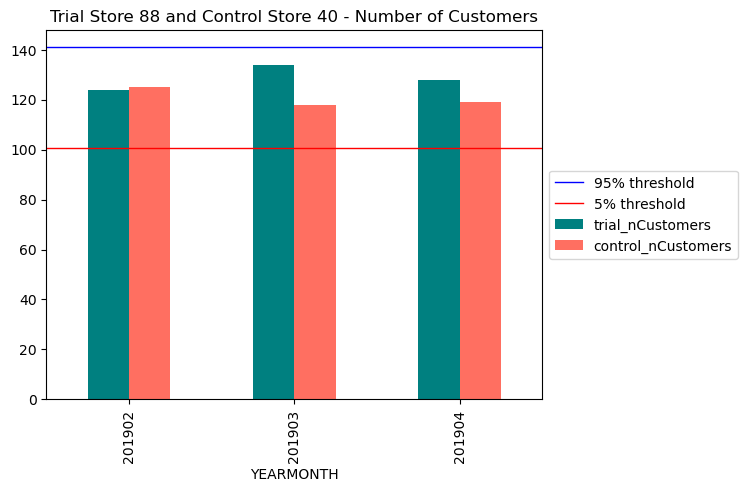

In [199]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control].rename(columns={"nCustomers": "control_nCustomers"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]].rename(columns={"nCustomers": "trial_nCustomers"})
    comb = b[["YEARMONTH", "trial_nCustomers"]].merge(a[["YEARMONTH", "control_nCustomers"]], on="YEARMONTH").set_index("YEARMONTH")
    
    # Specify colors for the bars
    comb.plot.bar(color=['#008080', '#ff6f61'])  
    
    cont_sc_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]["nCustomers"]
    std = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == control) & (scaledncust_vs_trial["trial_period"]=="pre")]["nCust_Percentage_Diff"].std()
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    plt.axhline(y=thresh95, linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5, linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store " + str(trial) + " and Control Store " + str(control) + " - Number of Customers")
    plt.savefig("TS {} and CS {} - nCustomers.png".format(trial, control), bbox_inches="tight")



We can see that Trial store 77 sales for Feb, March, and April exceeds 95% threshold of control store. Same goes to store 86 sales for all 3 trial months.

Trial store 77: Control store 233
Trial store 86: Control store 155
Trial store 88: Control store 40
Both trial store 77 and 86 showed significant increase in Total Sales and Number of Customers during trial period. But not for trial store 88. Perhaps the client knows if there's anything about trial 88 that differs it from the other two trial.
Overall the trial showed positive significant result.